In [1]:
from typing import List

import torch as ch
import torch.nn as nn
import torchvision

from ffcv.fields import IntField, RGBImageField
from ffcv.fields.decoders import IntDecoder, SimpleRGBImageDecoder
from ffcv.loader import Loader, OrderOption
from ffcv.pipeline.operation import Operation
from ffcv.transforms import RandomHorizontalFlip, Cutout, \
    RandomTranslate, Convert, ToDevice, ToTensor, ToTorchImage
from ffcv.transforms.common import Squeeze
from ffcv.writer import DatasetWriter

In [2]:
ch.cuda.is_available()

True

In [3]:
from torch.utils.data import RandomSampler, Subset

train = torchvision.datasets.CIFAR100('/tmp', train=True, download=True)
indices = ch.randperm(len(train))[:10000]  #5%: 2500,  20%:10000 
sample_ds = Subset(train, indices)
#train_dataset = RandomSampler(train, replacement=False, num_samples=2500)  #  Subset(train, indices)

datasets = {
    #'train': torchvision.datasets.CIFAR100('/tmp', train=True, download=True),
    'train': sample_ds,  #train_dataset,
    'test': torchvision.datasets.CIFAR100('/tmp', train=False, download=True)
}

for (name, ds) in datasets.items():
    writer = DatasetWriter(f'/tmp/cifar_{name}.beton', {
        'image': RGBImageField(),
        'label': IntField()
    })
    writer.from_indexed_dataset(ds)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 24876.89it/s]


In [4]:
CIFAR_MEAN = [125.307, 122.961, 113.8575]
CIFAR_STD = [51.5865, 50.847, 51.255]

BATCH_SIZE = 128

loaders = {}
for name in ['train', 'test']:
    label_pipeline: List[Operation] = [IntDecoder(), ToTensor(), ToDevice('cuda:0'), Squeeze()]
    image_pipeline: List[Operation] = [SimpleRGBImageDecoder()]

    # Add image transforms and normalization
    if name == 'train':
        image_pipeline.extend([
            RandomTranslate(padding=4),
            RandomHorizontalFlip()
            #Cutout(8, tuple(map(int, CIFAR_MEAN))), # Note Cutout is done before normalization.
        ])
    image_pipeline.extend([
        ToTensor(),
        ToDevice('cuda:0', non_blocking=True),
        ToTorchImage(),
        Convert(ch.float32),
        torchvision.transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ])

    # Create loaders
    loaders[name] = Loader(f'/tmp/cifar_{name}.beton',
                            batch_size=BATCH_SIZE,
                            num_workers=8,
                            order=OrderOption.RANDOM,
                            drop_last=(name == 'train'),
                            pipelines={'image': image_pipeline,
                                       'label': label_pipeline})

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.residual = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.residual(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [6]:
import matplotlib.pyplot as plt
def plot_stats(losses):
    e = len(losses)
    x_axis = np.arange(1, e + 1, 1)
    plt.figure()
    plt.plot(x_axis, losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.legend(loc='best')
    plt.title("Training Loss Stats Plot")
    plt.show()

In [7]:
NUM_CLASSES = 100
#model = ResNet(20, num_classes=NUM_CLASSES)
#model = model.to(memory_format=ch.channels_last).cuda()
model = ResNet18()
model = model.to(memory_format=ch.channels_last).cuda()

In [8]:
import numpy as np
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, lr_scheduler

EPOCHS = 120

opt = SGD(model.parameters(), lr= 0.1, weight_decay=1e-4)
#iters_per_epoch = 50000 // BATCH_SIZE

lr_scheduler1 = lr_scheduler.ConstantLR(opt, factor=1, total_iters=31)
lr_scheduler2 = lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)


scheduler = lr_scheduler.SequentialLR(opt, schedulers=[lr_scheduler1, lr_scheduler2], milestones=[31])
scaler = GradScaler()
loss_fn = CrossEntropyLoss(label_smoothing=0.1)

  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 0
Epoch: 0  Training loss: 3.866399002686525


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 1
Epoch: 1  Training loss: 3.2391923922758834


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 2
Epoch: 2  Training loss: 2.838073037832211


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 3
Epoch: 3  Training loss: 2.557789373397827


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 4
Epoch: 4  Training loss: 2.36988434730432


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 5
Epoch: 5  Training loss: 2.222152448617495


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 6
Epoch: 6  Training loss: 2.1003034026194842


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 7
Epoch: 7  Training loss: 2.007205962829101


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 8
Epoch: 8  Training loss: 1.9254258953607999


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 9
Epoch: 9  Training loss: 1.8497095383130586


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 10
Epoch: 10  Training loss: 1.7815981125220275


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 11
Epoch: 11  Training loss: 1.723695675837688


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 12
Epoch: 12  Training loss: 1.6680901194230104


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 13
Epoch: 13  Training loss: 1.614504447961465


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 14
Epoch: 14  Training loss: 1.5679045371520213


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 15
Epoch: 15  Training loss: 1.5199085568770385


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 16
Epoch: 16  Training loss: 1.4807935739174867


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 17
Epoch: 17  Training loss: 1.4372324738747035


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 18
Epoch: 18  Training loss: 1.3992586196997228


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 19
Epoch: 19  Training loss: 1.3645795953579438


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 20
Epoch: 20  Training loss: 1.3254429869162732


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 21
Epoch: 21  Training loss: 1.2915329691691277


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 22
Epoch: 22  Training loss: 1.258751362715012


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 23
Epoch: 23  Training loss: 1.2307000206067011


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 24
Epoch: 24  Training loss: 1.1997867351923233


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 25
Epoch: 25  Training loss: 1.1708704872009081


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 26
Epoch: 26  Training loss: 1.1462983935307234


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 27
Epoch: 27  Training loss: 1.1239788229648884


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 28
Epoch: 28  Training loss: 1.1033512081855383


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 29
Epoch: 29  Training loss: 1.0723433800232716


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 30
Epoch: 30  Training loss: 1.0567616395461255


/home/gordon/anaconda3/envs/ffcv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 31
Epoch: 31  Training loss: 1.037906895692532


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 32
Epoch: 32  Training loss: 1.0298691634948438


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 33
Epoch: 33  Training loss: 1.0089682637116848


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 34
Epoch: 34  Training loss: 0.9963981805703579


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 35
Epoch: 35  Training loss: 0.9815009919496683


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 36
Epoch: 36  Training loss: 0.9696970578951714


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 37
Epoch: 37  Training loss: 0.9592547652048943


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 38
Epoch: 38  Training loss: 0.9545780394321833


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 39
Epoch: 39  Training loss: 0.945978381847724


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 40
Epoch: 40  Training loss: 0.936879346309564


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 41
Epoch: 41  Training loss: 0.9293717809212514


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 42
Epoch: 42  Training loss: 0.9227313860868797


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 43
Epoch: 43  Training loss: 0.9160203611239409


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 44
Epoch: 44  Training loss: 0.9101112694312364


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 45
Epoch: 45  Training loss: 0.905277619147912


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 46
Epoch: 46  Training loss: 0.8996927875738877


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 47
Epoch: 47  Training loss: 0.8978879557206081


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 48
Epoch: 48  Training loss: 0.8912726798118689


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 49
Epoch: 49  Training loss: 0.889038874858465


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 50
Epoch: 50  Training loss: 0.8848084911321983


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 51
Epoch: 51  Training loss: 0.8802391111850738


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 52
Epoch: 52  Training loss: 0.8783289110049223


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 53
Epoch: 53  Training loss: 0.8760211154436454


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 54
Epoch: 54  Training loss: 0.8731336624194415


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 55
Epoch: 55  Training loss: 0.8705597412891877


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 56
Epoch: 56  Training loss: 0.8684627878360259


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 57
Epoch: 57  Training loss: 0.866872216646488


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 58
Epoch: 58  Training loss: 0.8654213914504418


  0%|          | 0/390 [00:00<?, ?it/s]

[0.1] 59
Epoch: 59  Training loss: 0.8623581285660084


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 60
Epoch: 60  Training loss: 0.8607468724250793


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 61
Epoch: 61  Training loss: 0.8458962798118591


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 62
Epoch: 62  Training loss: 0.8400720211175772


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 63
Epoch: 63  Training loss: 0.8376531762954517


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 64
Epoch: 64  Training loss: 0.8357121887879494


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 65
Epoch: 65  Training loss: 0.8345843772093455


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 66
Epoch: 66  Training loss: 0.8340525407057542


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 67
Epoch: 67  Training loss: 0.8335258988233712


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 68
Epoch: 68  Training loss: 0.832336605206514


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 69
Epoch: 69  Training loss: 0.8318794820553217


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 70
Epoch: 70  Training loss: 0.8313322437115205


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 71
Epoch: 71  Training loss: 0.8307704210281373


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 72
Epoch: 72  Training loss: 0.8303781918990306


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 73
Epoch: 73  Training loss: 0.8298658014872136


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 74
Epoch: 74  Training loss: 0.8296433587869009


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 75
Epoch: 75  Training loss: 0.8293461799621582


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 76
Epoch: 76  Training loss: 0.8288689868572431


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 77
Epoch: 77  Training loss: 0.8292526193154164


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 78
Epoch: 78  Training loss: 0.8282999734083811


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 79
Epoch: 79  Training loss: 0.8281564787412301


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 80
Epoch: 80  Training loss: 0.827892442085804


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 81
Epoch: 81  Training loss: 0.8273286798061469


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 82
Epoch: 82  Training loss: 0.8272395765170073


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 83
Epoch: 83  Training loss: 0.8270264958723997


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 84
Epoch: 84  Training loss: 0.8267739748343443


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 85
Epoch: 85  Training loss: 0.8262480011353126


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 86
Epoch: 86  Training loss: 0.8262665620216957


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 87
Epoch: 87  Training loss: 0.8261213759581248


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 88
Epoch: 88  Training loss: 0.8258013578561636


  0%|          | 0/390 [00:00<?, ?it/s]

[0.010000000000000002] 89
Epoch: 89  Training loss: 0.8254764537016551


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 90
Epoch: 90  Training loss: 0.8254393932146904


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 91
Epoch: 91  Training loss: 0.8250887552897136


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 92
Epoch: 92  Training loss: 0.8244446742228972


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 93
Epoch: 93  Training loss: 0.8243456886364864


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 94
Epoch: 94  Training loss: 0.8246359114463513


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 95
Epoch: 95  Training loss: 0.8243867817597511


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 96
Epoch: 96  Training loss: 0.8247390635502644


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 97
Epoch: 97  Training loss: 0.8242298991252215


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 98
Epoch: 98  Training loss: 0.8242521937076862


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 99
Epoch: 99  Training loss: 0.8243290111040458


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 100
Epoch: 100  Training loss: 0.8245177591458345


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 101
Epoch: 101  Training loss: 0.8243379411024925


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 102
Epoch: 102  Training loss: 0.8242436742171263


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 103
Epoch: 103  Training loss: 0.8239164462456336


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 104
Epoch: 104  Training loss: 0.8240715187329513


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 105
Epoch: 105  Training loss: 0.8243198926632221


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 106
Epoch: 106  Training loss: 0.8241974000747387


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 107
Epoch: 107  Training loss: 0.8239988745787205


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 108
Epoch: 108  Training loss: 0.8242417885706975


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 109
Epoch: 109  Training loss: 0.8240808373842484


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 110
Epoch: 110  Training loss: 0.8239330196991945


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 111
Epoch: 111  Training loss: 0.8240002271456596


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 112
Epoch: 112  Training loss: 0.8243503408554272


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 113
Epoch: 113  Training loss: 0.8240288855173649


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 114
Epoch: 114  Training loss: 0.8238378127415975


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 115
Epoch: 115  Training loss: 0.8238409204360766


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 116
Epoch: 116  Training loss: 0.8236854386635316


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 117
Epoch: 117  Training loss: 0.8239069854601836


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 118
Epoch: 118  Training loss: 0.8238181399993407


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0010000000000000002] 119
Epoch: 119  Training loss: 0.8236703016819098


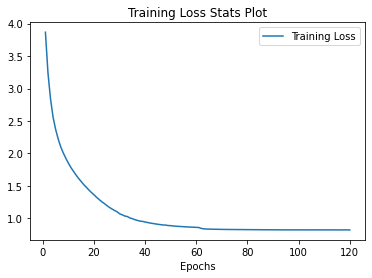

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy: 74.9%


In [36]:
from tqdm.notebook import tqdm

training_losses = []

for ep in range(EPOCHS):
    
    epoch_loss = 0
    
    for ims, labs in tqdm(loaders['train']):
        opt.zero_grad(set_to_none=True)
        with autocast():
            out = model(ims)
            loss = loss_fn(out, labs)
            epoch_loss += loss.item()
            
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
    scheduler.step()
    print(scheduler.get_last_lr(), ep)
    
    epoch_loss = epoch_loss/ len(loaders['train'])
    training_losses.append(epoch_loss)
    print( f'Epoch: {ep}  Training loss: {epoch_loss}')

plot_stats(training_losses)

model.eval()
with ch.no_grad():
    total_correct, total_num = 0., 0.
    for ims, labs in tqdm(loaders['test']):
        with autocast():
            out = model(ims)   #(model(ims) + model(ch.fliplr(ims))) / 2. # Test-time augmentation
            total_correct += out.argmax(1).eq(labs).sum().cpu().item()
            total_num += ims.shape[0]

    print(f'Accuracy: {total_correct / total_num * 100:.1f}%')

  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 0
Epoch: 0  Training loss: 4.322041016358596


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 1
Epoch: 1  Training loss: 3.9603749910990396


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 2
Epoch: 2  Training loss: 3.7376670776269374


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 3
Epoch: 3  Training loss: 3.5755376510131054


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 4
Epoch: 4  Training loss: 3.4327673881481857


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 5
Epoch: 5  Training loss: 3.3194961914649377


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 6
Epoch: 6  Training loss: 3.166859431144519


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 7
Epoch: 7  Training loss: 3.0607264775496263


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 8
Epoch: 8  Training loss: 2.930908958117167


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 9
Epoch: 9  Training loss: 2.830118925143511


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 10
Epoch: 10  Training loss: 2.713714660742344


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 11
Epoch: 11  Training loss: 2.6200552445191603


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 12
Epoch: 12  Training loss: 2.54403922191033


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 13
Epoch: 13  Training loss: 2.4271339850547986


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 14
Epoch: 14  Training loss: 2.3367532461117477


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 15
Epoch: 15  Training loss: 2.2611671594473033


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 16
Epoch: 16  Training loss: 2.1840572479443674


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 17
Epoch: 17  Training loss: 2.0907247815376673


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 18
Epoch: 18  Training loss: 2.0192755048091593


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 19
Epoch: 19  Training loss: 1.9577536231432207


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 20
Epoch: 20  Training loss: 1.8896616651461675


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 21
Epoch: 21  Training loss: 1.816312013528286


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 22
Epoch: 22  Training loss: 1.7240804051741576


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 23
Epoch: 23  Training loss: 1.6725411888880608


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 24
Epoch: 24  Training loss: 1.6097511924230135


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 25
Epoch: 25  Training loss: 1.5374658046624599


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 26
Epoch: 26  Training loss: 1.4655717397347474


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 27
Epoch: 27  Training loss: 1.4126358139209259


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 28
Epoch: 28  Training loss: 1.349767260062389


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 29
Epoch: 29  Training loss: 1.3035455071009123


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 30
Epoch: 30  Training loss: 1.254204695041363


/home/gordon/anaconda3/envs/ffcv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 31
Epoch: 31  Training loss: 1.2232381655619695


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 32
Epoch: 32  Training loss: 1.1844562261532514


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 33
Epoch: 33  Training loss: 1.1483796254182472


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 34
Epoch: 34  Training loss: 1.1174306579125233


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 35
Epoch: 35  Training loss: 1.0831819390639281


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 36
Epoch: 36  Training loss: 1.0703960489004085


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 37
Epoch: 37  Training loss: 1.0295546941268139


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 38
Epoch: 38  Training loss: 1.0135639027143135


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 39
Epoch: 39  Training loss: 1.0018851222136083


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 40
Epoch: 40  Training loss: 0.9838505960427798


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 41
Epoch: 41  Training loss: 0.9717621245445349


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 42
Epoch: 42  Training loss: 0.9628197390299577


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 43
Epoch: 43  Training loss: 0.9530323117207258


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 44
Epoch: 44  Training loss: 0.9416245153317084


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 45
Epoch: 45  Training loss: 0.9309827043459966


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 46
Epoch: 46  Training loss: 0.9299329565121577


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 47
Epoch: 47  Training loss: 0.9231726985711318


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 48
Epoch: 48  Training loss: 0.9163639377325009


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 49
Epoch: 49  Training loss: 0.9107892108269227


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 50
Epoch: 50  Training loss: 0.9070776670407026


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 51
Epoch: 51  Training loss: 0.9029491818868197


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 52
Epoch: 52  Training loss: 0.8960514152661349


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 53
Epoch: 53  Training loss: 0.8952975869178772


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 54
Epoch: 54  Training loss: 0.895843410339111


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 55
Epoch: 55  Training loss: 0.8887884410528036


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 56
Epoch: 56  Training loss: 0.8833133005178891


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 57
Epoch: 57  Training loss: 0.8800951548111744


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 58
Epoch: 58  Training loss: 0.8806513395064917


  0%|          | 0/78 [00:00<?, ?it/s]

[0.1] 59
Epoch: 59  Training loss: 0.8762617478003869


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 60
Epoch: 60  Training loss: 0.8753026670370346


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 61
Epoch: 61  Training loss: 0.86503188426678


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 62
Epoch: 62  Training loss: 0.8581488652107043


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 63
Epoch: 63  Training loss: 0.8555738138846862


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 64
Epoch: 64  Training loss: 0.8531722181882614


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 65
Epoch: 65  Training loss: 0.8530397017796835


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 66
Epoch: 66  Training loss: 0.8515318066645892


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 67
Epoch: 67  Training loss: 0.8515555659929911


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 68
Epoch: 68  Training loss: 0.8505091139903436


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 69
Epoch: 69  Training loss: 0.8504597407120925


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 70
Epoch: 70  Training loss: 0.849623176531914


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 71
Epoch: 71  Training loss: 0.8486750561457413


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 72
Epoch: 72  Training loss: 0.8488313769682859


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 73
Epoch: 73  Training loss: 0.8485011466038532


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 74
Epoch: 74  Training loss: 0.8483185439537733


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 75
Epoch: 75  Training loss: 0.8473379833576007


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 76
Epoch: 76  Training loss: 0.8479663615043347


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 77
Epoch: 77  Training loss: 0.8468388150899838


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 78
Epoch: 78  Training loss: 0.8467713984159323


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 79
Epoch: 79  Training loss: 0.8466567389475994


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 80
Epoch: 80  Training loss: 0.8454669362459427


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 81
Epoch: 81  Training loss: 0.8455453423353342


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 82
Epoch: 82  Training loss: 0.8450669203049097


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 83
Epoch: 83  Training loss: 0.8452931543191274


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 84
Epoch: 84  Training loss: 0.8450351533217307


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 85
Epoch: 85  Training loss: 0.8448533224753845


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 86
Epoch: 86  Training loss: 0.8440441214121305


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 87
Epoch: 87  Training loss: 0.8441375310604389


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 88
Epoch: 88  Training loss: 0.8435358642003475


  0%|          | 0/78 [00:00<?, ?it/s]

[0.010000000000000002] 89
Epoch: 89  Training loss: 0.8440791865189871


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 90
Epoch: 90  Training loss: 0.8437636762093275


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 91
Epoch: 91  Training loss: 0.8433111401704642


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 92
Epoch: 92  Training loss: 0.8436389435560275


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 93
Epoch: 93  Training loss: 0.8431683335548792


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 94
Epoch: 94  Training loss: 0.84311076769462


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 95
Epoch: 95  Training loss: 0.8430878038589771


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 96
Epoch: 96  Training loss: 0.8419250249862671


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 97
Epoch: 97  Training loss: 0.8432600215459481


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 98
Epoch: 98  Training loss: 0.8427879283061395


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 99
Epoch: 99  Training loss: 0.8421940558995956


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 100
Epoch: 100  Training loss: 0.8422010892476791


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 101
Epoch: 101  Training loss: 0.8419360266282008


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 102
Epoch: 102  Training loss: 0.8428436471865728


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 103
Epoch: 103  Training loss: 0.8429428468912076


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 104
Epoch: 104  Training loss: 0.8426621135992881


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 105
Epoch: 105  Training loss: 0.8425953029057919


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 106
Epoch: 106  Training loss: 0.8428459832301507


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 107
Epoch: 107  Training loss: 0.8424364886222742


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 108
Epoch: 108  Training loss: 0.8417054300124829


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 109
Epoch: 109  Training loss: 0.8418801251130227


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 110
Epoch: 110  Training loss: 0.8415409372403071


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 111
Epoch: 111  Training loss: 0.8424857961825836


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 112
Epoch: 112  Training loss: 0.8423738135741308


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 113
Epoch: 113  Training loss: 0.8419128503554907


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 114
Epoch: 114  Training loss: 0.841945469379425


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 115
Epoch: 115  Training loss: 0.8422141564198029


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 116
Epoch: 116  Training loss: 0.8422407431480212


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 117
Epoch: 117  Training loss: 0.8414415350327125


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 118
Epoch: 118  Training loss: 0.8424678162122384


  0%|          | 0/78 [00:00<?, ?it/s]

[0.0010000000000000002] 119
Epoch: 119  Training loss: 0.8422121099936657


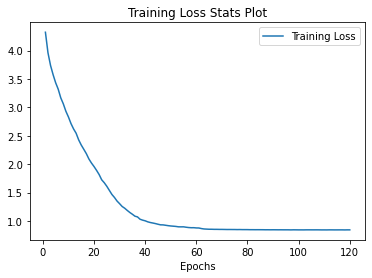

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy: 50.1%


In [48]:
from tqdm.notebook import tqdm

training_losses = []

for ep in range(EPOCHS):
    
    epoch_loss = 0
    
    for ims, labs in tqdm(loaders['train']):
        opt.zero_grad(set_to_none=True)
        with autocast():
            out = model(ims)
            loss = loss_fn(out, labs)
            epoch_loss += loss.item()
            
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
    scheduler.step()
    print(scheduler.get_last_lr(), ep)
    
    epoch_loss = epoch_loss/ len(loaders['train'])
    training_losses.append(epoch_loss)
    print( f'Epoch: {ep}  Training loss: {epoch_loss}')

plot_stats(training_losses)

model.eval()
with ch.no_grad():
    total_correct, total_num = 0., 0.
    for ims, labs in tqdm(loaders['test']):
        with autocast():
            out = model(ims)   #(model(ims) + model(ch.fliplr(ims))) / 2. # Test-time augmentation
            total_correct += out.argmax(1).eq(labs).sum().cpu().item()
            total_num += ims.shape[0]

    print(f'Accuracy: {total_correct / total_num * 100:.1f}%')